# Gradient Boosting Regressor (AMD)

In this notebook, I delve into the application of the Gradient Boosting Regressor, a powerful ensemble machine learning technique, for predicting the 30-day future close price percent change of AMD (Advanced Micro Devices, Inc.) stock.

## Problem Recap
Our primary goal remains predicting stock price movements, a complex task influenced by various factors in the volatile market. Leveraging machine learning models, I aim to gain insights into the dynamics of AMD's stock and enhance our predictive capabilities.

## Previous Notebooks
Before diving into Gradient Boosting, I explored the application of a Linear Regression model on stock data. For a stable company like KO (The Coca-Cola Company), I investigated Random Forest Regressor. Now, I shift my focus to AMD, a more volatile stock, and leverage the power of Gradient Boosting.

## Gradient Boosting Regressor
Gradient Boosting builds a strong predictive model by combining the strengths of multiple weak learners. It sequentially improves on the weaknesses of the preceding models, creating a robust ensemble. We'll explore how this methodology performs on AMD's stock data, considering its sensitivity to market dynamics.

## Expectations
Stock market prediction inherently involves uncertainty, and while machine learning models can offer valuable insights, complete accuracy remains challenging. Our aim is to iteratively refine our understanding, assess the model's performance, and draw meaningful conclusions.

---


In [568]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel

import sys
sys.path.append('../src')

from yf_dataset import *
from ta_features import *
from preprocessing import *

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression


In [569]:
ticker = 'amd'
label = 'AMD'
start_date = '2017-01-01'
close_price_period = '1d'
target_pct_change_period = 30

In [570]:
amd_df = get_stock_data(ticker, start_date, period=close_price_period)
format_col_names(amd_df)

[*********************100%%**********************]  1 of 1 completed


In [571]:
# Check for missing values in each column
missing_values = amd_df.isnull().sum()

# Display the result
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64


In [572]:
amd_df.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2017-01-03,11.42,11.65,11.02,11.43,11.43,55182000
2017-01-04,11.45,11.52,11.24,11.43,11.43,40781200
2017-01-05,11.43,11.69,11.23,11.24,11.24,38855200
2017-01-06,11.29,11.49,11.11,11.32,11.32,34453500
2017-01-09,11.37,11.64,11.31,11.49,11.49,37304800


In [573]:
add_pct_ch_and_future(amd_df, period = target_pct_change_period)

c:\Users\user\Desktop\FMLProject\FML\notebooks\../src\ta_features.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  df[str(period) + 'd_close_future_pct'] = df[str(period) + 'd_future_close'].pct_change(period) #calc future % change


Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct'],
      dtype='object')

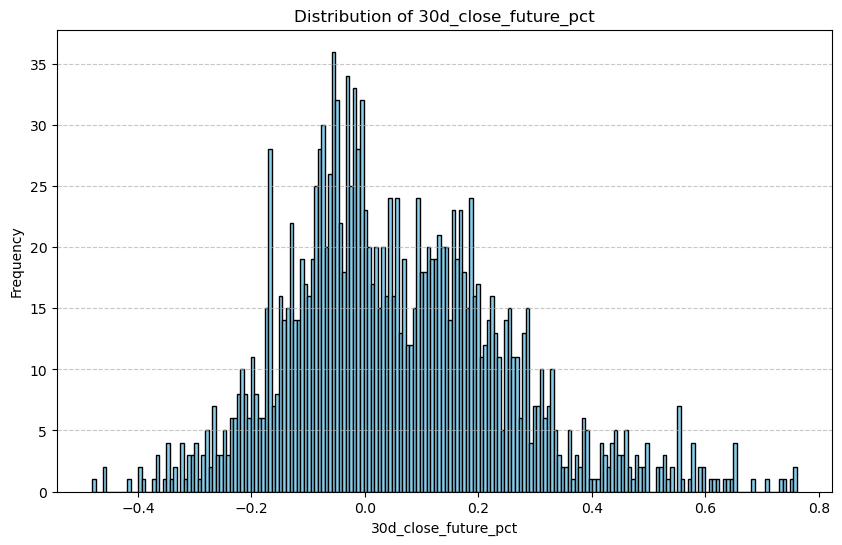

In [574]:
target_column = f'{target_pct_change_period}d_close_future_pct'

# Plot the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(amd_df[target_column], bins=200, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {target_column}')
plt.xlabel(target_column)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [575]:
add_sma_rsi_sma_x_rsi(amd_df, [14, 20, 30, 60, 100])
add_ema(amd_df, [14, 20, 50, 100])
add_wma(amd_df, [14, 20, 50, 100])


add_volume_1d_pct_change_sma(amd_df, 10)
add_volume_1d_pct_change_sma(amd_df, 30)
add_volume_1d_pct_change_sma(amd_df, 60)
add_volume_1d_pct_change_sma(amd_df, 90)

amd_df = add_datetime_features(amd_df,["month", "quarter"])


amd_df['Log_Volume'] = amd_df['Volume'].apply(np.log)

In [576]:
add_n_day_std(amd_df, 14)
add_n_day_std(amd_df, 30)
add_n_day_std(amd_df, 60)

add_lower_confidence_interval(amd_df, 14)
add_lower_confidence_interval(amd_df, 30)
add_lower_confidence_interval(amd_df, 60)

add_upper_confidence_interval(amd_df, 14)
add_upper_confidence_interval(amd_df, 30)
add_upper_confidence_interval(amd_df, 60)


Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma14', 'rsi14',
       'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma30', 'rsi30',
       'SMAxRSI_30', 'sma60', 'rsi60', 'SMAxRSI_60', 'sma100', 'rsi100',
       'SMAxRSI_100', 'ema14', 'ema20', 'ema50', 'ema100', 'wma14', 'wma20',
       'wma50', 'wma100', 'Volume_1d_change', 'Volume_10d_change_SMA',
       'Volume_30d_change_SMA', 'Volume_60d_change_SMA',
       'Volume_90d_change_SMA', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'quarter_1', 'quarter_2', 'quarter_3', 'Log_Volume',
       '14d_std', '30d_std', '60d_std', '14d_upper_conf_interval',
       '30d_upper_conf_interval', '60d_upper_conf_interval'],
      dtype='object')

In [577]:
add_downward_pressure(amd_df)
add_upward_pressure(amd_df)

add_cumulative_return(amd_df)

amd_df = add_stochastic_oscillator(amd_df)

In [578]:
add_atr(amd_df, 14)
amd_df = add_adx(amd_df, 14)
amd_df = add_adx(amd_df, 30)
amd_df = add_adx(amd_df, 60)

In [579]:
amd_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', '30d_close_pct',
       '30d_future_close', '30d_close_future_pct', 'sma14', 'rsi14',
       'SMAxRSI_14', 'sma20', 'rsi20', 'SMAxRSI_20', 'sma30', 'rsi30',
       'SMAxRSI_30', 'sma60', 'rsi60', 'SMAxRSI_60', 'sma100', 'rsi100',
       'SMAxRSI_100', 'ema14', 'ema20', 'ema50', 'ema100', 'wma14', 'wma20',
       'wma50', 'wma100', 'Volume_1d_change', 'Volume_10d_change_SMA',
       'Volume_30d_change_SMA', 'Volume_60d_change_SMA',
       'Volume_90d_change_SMA', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'quarter_1', 'quarter_2', 'quarter_3', 'Log_Volume',
       '14d_std', '30d_std', '60d_std', '14d_upper_conf_interval',
       '30d_upper_conf_interval', '60d_upper_conf_interval',
       'Downward_Pressure', 'Upward_Pressure', 'Cumulative_Return',
       'STOCHk_14_3_3', 'STOCHd_14_3_3', 'ATR', 'ADX_14', 'DMP_14', 'DMN_14',
       

In [580]:
amd_df.dropna(inplace=True)
amd_df.head()

,Open,High,Low,Close,Adj_Close,Volume,30d_close_pct,30d_future_close,30d_close_future_pct,sma14,...,ATR,ADX_14,DMP_14,DMN_14,ADX_30,DMP_30,DMN_30,ADX_60,DMP_60,DMN_60
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-23,14.15,14.67,13.90,14.17,14.17,200777300,0.280036,13.43,-0.052223,12.532143,...,0.759980,18.338503,37.365367,14.974332,11.565814,31.725046,20.191709,7.058689,29.232347,22.335667
2017-06-26,14.39,14.49,13.84,14.08,14.08,101012500,0.250444,13.11,-0.068892,12.678571,...,0.752123,19.967931,35.058487,14.619729,11.912957,30.713911,19.842361,7.212675,28.678899,22.087554
2017-06-27,13.76,14.04,13.37,13.40,13.40,89319700,0.173380,12.83,-0.042537,12.751429,...,0.749114,20.591042,32.684758,18.111921,12.056615,29.646222,21.453767,7.283622,28.088180,22.996111
2017-06-28,13.65,13.70,13.09,13.23,13.23,85266900,0.037647,12.12,-0.083900,12.775000,...,0.739176,20.676988,30.757897,19.750204,12.085945,28.757720,22.186473,7.307465,27.591626,23.401044
2017-06-29,13.06,13.15,12.45,12.60,12.60,87634400,0.125000,12.23,-0.029365,12.797857,...,0.742092,19.742876,28.448424,24.428119,11.878611,27.661123,24.469257,7.232858,26.971595,24.719017


In [581]:
# Check for duplicate column names
duplicates = amd_df.columns[amd_df.columns.duplicated()]
print("Duplicate Columns:", duplicates)

Duplicate Columns: Index([], dtype='object')


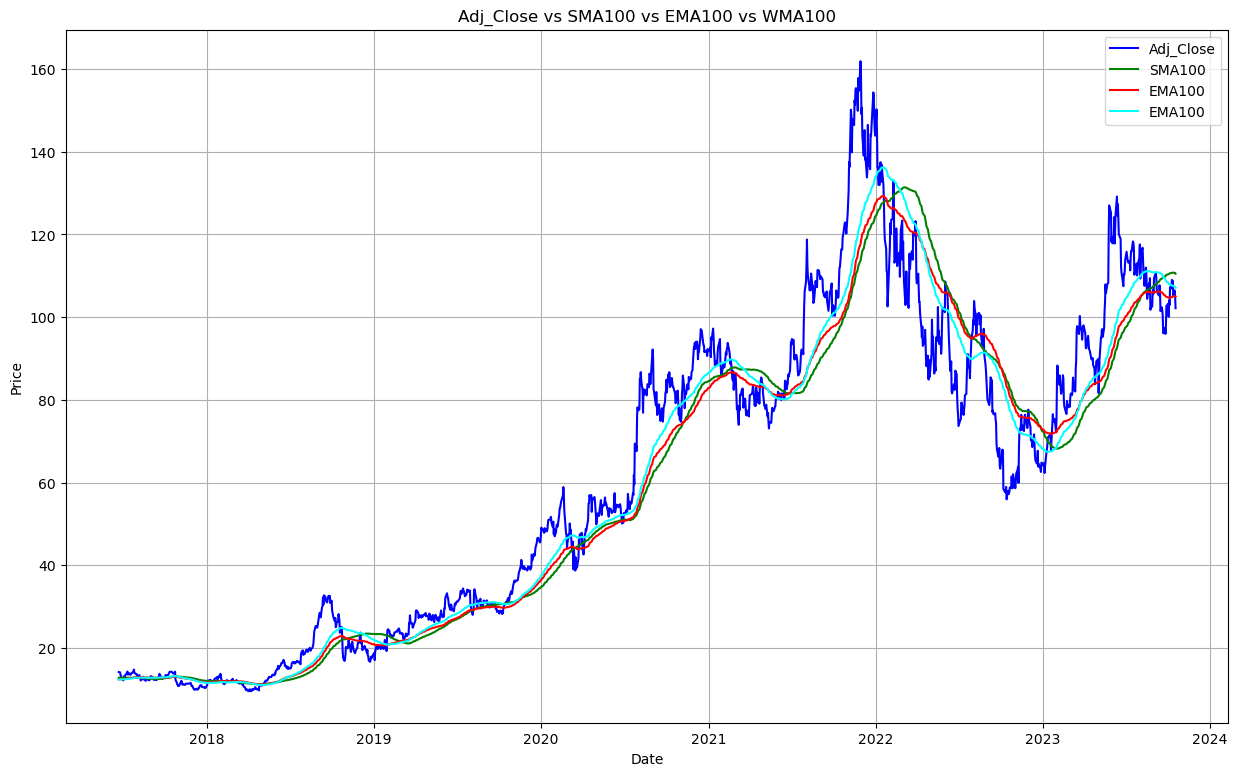

In [582]:
# Plotting
plt.figure(figsize=(15, 9))

plt.plot(amd_df['Adj_Close'], label='Adj_Close', color='blue')

plt.plot(amd_df['sma100'], label='SMA100', color='green')

plt.plot(amd_df['ema100'], label='EMA100', color='red')

plt.plot(amd_df['wma100'], label='EMA100', color='cyan')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Adj_Close vs SMA100 vs EMA100 vs WMA100')
plt.legend()
plt.grid(True)
plt.show()

In [583]:
features, target = split_features_target(amd_df, f'{target_pct_change_period}d_close_future_pct', [f'{target_pct_change_period}d_future_close'])

In [584]:
X = amd_df[features]
y = amd_df[target]

X.shape,y.shape
len(features)

71

In [585]:
# Create a time series split
n_splits = 6
n_samples = X.shape[0]
s = n_samples//(n_splits + 1)          

X_train, X_test = X[ :-s], X[-s: ]
y_train, y_test = y[ :-s], y[-s: ]

y_train.shape, y_test.shape

((1364,), (227,))

In [586]:
# Mutual Information Feature Selection
mi_selector = SelectKBest(mutual_info_regression, k=40)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
selected_features_mi = X.columns[mi_selector.get_support()]

# P-value Feature Selection
f_selector = SelectKBest(f_regression, k=40)
X_train_f = f_selector.fit_transform(X_train, y_train)
selected_features_f = X.columns[f_selector.get_support()]

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be

In [587]:
# Obtain the list of features present in both selected_features_mi and selected_features_f
common_features = set(selected_features_mi) & set(selected_features_f)

# Print the common features
print("Common Features:", common_features)

Common Features: {'SMAxRSI_30', 'ATR', 'Adj_Close', 'sma14', 'ema100', 'DMN_60', 'ema14', 'Low', 'ADX_60', 'ema20', 'sma100', 'SMAxRSI_100', 'High', 'SMAxRSI_14', 'sma20', '30d_std', 'Cumulative_Return', '14d_std', 'wma14', 'Close', 'SMAxRSI_20', '14d_upper_conf_interval', 'Open', 'SMAxRSI_60', '60d_std', 'ADX_30', 'wma100', 'wma20', '60d_upper_conf_interval', 'sma30', '30d_upper_conf_interval', 'wma50', 'sma60', 'ema50'}


In [588]:
# Convert the set to a list before using it as a column indexer
common_features_list = list(common_features)
len(common_features)

34

In [589]:
X_train = X_train[common_features_list]
X_test = X_test[common_features_list]

In [590]:
# Identify columns to exclude from scaling
exclude_prefixes = ['weekday_','month_', 'quarter_']
categorical_features = [col for col in common_features if any(col.startswith(prefix) for prefix in exclude_prefixes)]
# Transform to 1s and 0s
X_train[categorical_features] = X_train[categorical_features].astype(int)
X_test[categorical_features] = X_test[categorical_features].astype(int)

In [591]:
X_train.head()

,SMAxRSI_30,ATR,Adj_Close,sma14,ema100,DMN_60,ema14,Low,ADX_60,ema20,...,60d_std,ADX_30,wma100,wma20,60d_upper_conf_interval,sma30,30d_upper_conf_interval,wma50,sma60,ema50
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-23,699.885357,0.759980,14.17,12.532143,12.392609,22.335667,12.666139,13.90,7.058689,12.407150,...,1.295796,11.565814,12.374400,12.527429,14.806925,11.831667,13.805992,11.901867,12.215333,12.166169
2017-06-26,699.561546,0.752123,14.08,12.678571,12.426023,22.087554,12.854654,13.84,7.212675,12.566469,...,1.296521,11.912957,12.400071,12.716810,14.808876,11.925667,14.050182,11.986886,12.215833,12.241221
2017-06-27,660.379478,0.749114,13.40,12.751429,12.445310,22.996111,12.927367,13.37,7.283622,12.645853,...,1.269652,12.056615,12.411877,12.826762,14.735970,11.991667,14.173428,12.043851,12.196667,12.286663
2017-06-28,650.956677,0.739176,13.23,12.775000,12.460848,23.401044,12.967718,13.09,7.307465,12.701486,...,1.236272,12.085945,12.420095,12.909667,14.645710,12.007667,14.219277,12.093671,12.173167,12.323657
2017-06-29,616.649717,0.742092,12.60,12.797857,12.463604,24.719017,12.918689,12.45,7.232858,12.691821,...,1.209901,11.878611,12.415642,12.922857,14.566969,12.054333,14.254475,12.118565,12.147167,12.334494


In [592]:
X_test.shape

(227, 34)

In [594]:
X_train.head()

,SMAxRSI_30,ATR,Adj_Close,sma14,ema100,DMN_60,ema14,Low,ADX_60,ema20,...,60d_std,ADX_30,wma100,wma20,60d_upper_conf_interval,sma30,30d_upper_conf_interval,wma50,sma60,ema50
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-23,699.885357,0.759980,14.17,12.532143,12.392609,22.335667,12.666139,13.90,7.058689,12.407150,...,1.295796,11.565814,12.374400,12.527429,14.806925,11.831667,13.805992,11.901867,12.215333,12.166169
2017-06-26,699.561546,0.752123,14.08,12.678571,12.426023,22.087554,12.854654,13.84,7.212675,12.566469,...,1.296521,11.912957,12.400071,12.716810,14.808876,11.925667,14.050182,11.986886,12.215833,12.241221
2017-06-27,660.379478,0.749114,13.40,12.751429,12.445310,22.996111,12.927367,13.37,7.283622,12.645853,...,1.269652,12.056615,12.411877,12.826762,14.735970,11.991667,14.173428,12.043851,12.196667,12.286663
2017-06-28,650.956677,0.739176,13.23,12.775000,12.460848,23.401044,12.967718,13.09,7.307465,12.701486,...,1.236272,12.085945,12.420095,12.909667,14.645710,12.007667,14.219277,12.093671,12.173167,12.323657
2017-06-29,616.649717,0.742092,12.60,12.797857,12.463604,24.719017,12.918689,12.45,7.232858,12.691821,...,1.209901,11.878611,12.415642,12.922857,14.566969,12.054333,14.254475,12.118565,12.147167,12.334494


In [595]:
tscv = TimeSeriesSplit(n_splits=n_splits-1)
scaler = StandardScaler()

def smape_score(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    # Check if both y_true and y_pred are 0
    both_zero_mask = (y_true == 0) & (y_pred == 0)
    # If both are 0, set diff to 0 to avoid division by zero
    diff = np.where(both_zero_mask, 0, np.abs(y_true - y_pred) / denominator)
    return 100 * np.mean(diff)

# Define the custom scoring function for RMSE
def rmse_score(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # Negate the RMSE to use as a score


# Make a scorer from the custom RMSE function
r2_scorer = make_scorer(r2_score)

explained_var_scorer = make_scorer(explained_variance_score)

# Use make_scorer to create a scorer for GridSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
# Make SMAPE a scorer for scikit-learn
smape_scorer = make_scorer(smape_score, greater_is_better=False)

# Specify multiple scoring metrics, including the custom metric
scoring = {
    'r2': r2_scorer,
    'explained_variance': explained_var_scorer,
    'sMAPE': smape_scorer,
    'MAPE': mape_scorer
}

# Choose one metric as the refit metric
refit_metric = 'sMAPE'

# Identify columns to scale
features_to_scale = [col for col in common_features if col not in categorical_features]
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, features_to_scale),
        ('powerTransformer', PowerTransformer(method='yeo-johnson'), features_to_scale),
        ('passthrough', 'passthrough', categorical_features)  # This passes through the specified features
    ],
    remainder='drop'  # Drop any columns not explicitly specified
)

print(preprocessor.get_params())

# Define the pipeline with a GradientBoostingRegressor and a StandardScaler
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingRegressor())
])


# {'gb__learning_rate': 0.2, 'gb__max_depth': 160, 'gb__max_features': 12, 'gb__min_samples_split': 4, 'gb__n_estimators': 450}
param_grid = {
    'gb__max_features': [12],
    'gb__n_estimators': [450],  # Adjust as needed
    'gb__learning_rate': [0.2],  # Adjust as needed
    'gb__max_depth': [160],  # Adjust as needed
    'gb__min_samples_split': [4],  # Adjust as needed
    # 'gb__min_samples_leaf': [2, 3, 5, 10, 20],  # Adjust as needed
}

# Perform grid search with cross-validation using the specified scoring metrics
grid_search_gb = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=scoring, refit=refit_metric, n_jobs=7)
grid_search_gb.fit(X_train, y_train)

# Access the best parameters and corresponding scores
print("Best Hyperparameters:", grid_search_gb.best_params_)
print("Best Scores:")
# Print the best score for each metric
for metric in scoring.keys():
    key = f'mean_test_{metric}'
    best_score = grid_search_gb.cv_results_[key][grid_search_gb.best_index_]
    print(f"Best mean {metric} Score: {best_score}")

    key = f'std_test_{metric}'
    best_score = grid_search_gb.cv_results_[key][grid_search_gb.best_index_]
    print(f"Best std {metric} Score: {best_score}")

    key = f'rank_test_{metric}'
    best_score = grid_search_gb.cv_results_[key][grid_search_gb.best_index_]
    print(f"Best rank {metric} Score: {best_score}")

best_model_gb = grid_search_gb.best_estimator_

{'n_jobs': None, 'remainder': 'drop', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('scaler', StandardScaler(), ['SMAxRSI_30', 'ATR', 'Adj_Close', 'sma14', 'ema100', 'DMN_60', 'ema14', 'Low', 'ADX_60', 'ema20', 'sma100', 'SMAxRSI_100', 'High', 'SMAxRSI_14', 'sma20', '30d_std', 'Cumulative_Return', '14d_std', 'wma14', 'Close', 'SMAxRSI_20', '14d_upper_conf_interval', 'Open', 'SMAxRSI_60', '60d_std', 'ADX_30', 'wma100', 'wma20', '60d_upper_conf_interval', 'sma30', '30d_upper_conf_interval', 'wma50', 'sma60', 'ema50']), ('powerTransformer', PowerTransformer(), ['SMAxRSI_30', 'ATR', 'Adj_Close', 'sma14', 'ema100', 'DMN_60', 'ema14', 'Low', 'ADX_60', 'ema20', 'sma100', 'SMAxRSI_100', 'High', 'SMAxRSI_14', 'sma20', '30d_std', 'Cumulative_Return', '14d_std', 'wma14', 'Close', 'SMAxRSI_20', '14d_upper_conf_interval', 'Open', 'SMAxRSI_60', '60d_std', 'ADX_30', 'wma100', 'wma20', '60d_upper_conf_interval', 'sma30', '30d_upper_conf_interval', 'wma50', 'sma60', 'ema50']),

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

Best Hyperparameters: {'gb__learning_rate': 0.2, 'gb__max_depth': 160, 'gb__max_features': 12, 'gb__min_samples_split': 4, 'gb__n_estimators': 450}
Best Scores:
Best mean r2 Score: -0.9443713151287059
Best std r2 Score: 0.5596716856466322
Best rank r2 Score: 1
Best mean explained_variance Score: -0.13935220429248174
Best std explained_variance Score: 0.32833540319159904
Best rank explained_variance Score: 1
Best mean sMAPE Score: -72.43705872945101
Best std sMAPE Score: 6.450250396458061
Best rank sMAPE Score: 1
Best mean MAPE Score: -330441748247.1979
Best std MAPE Score: 660883496486.6145
Best rank MAPE Score: 1


In [596]:
y_pred = best_model_gb.predict(X_test)

score = -scoring[refit_metric](best_model_gb, X_test, y_test)
print(f'{refit_metric}: ', score)

sMAPE:  55.92140781651682


c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

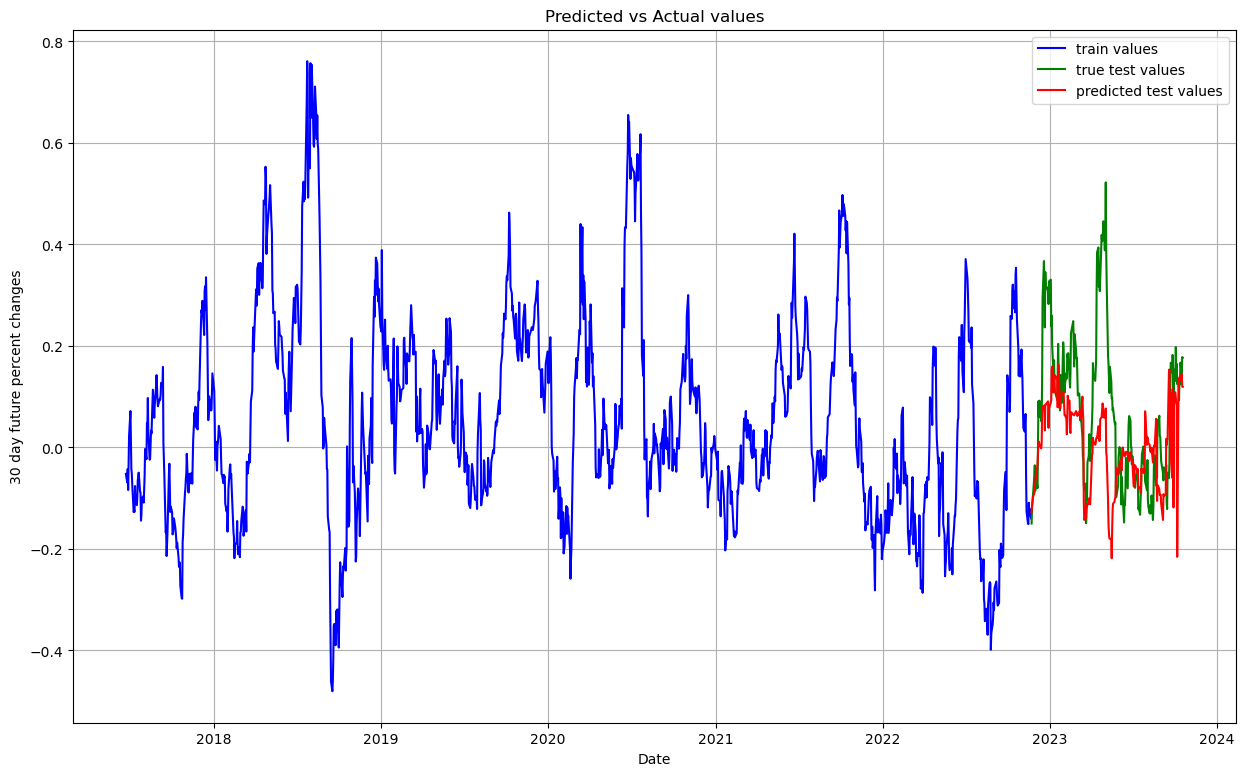

In [597]:
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.set_index(y_test.index)

# Plotting
plt.figure(figsize=(15, 9))

plt.plot(y_train, label='train values', color='blue')
plt.plot(y_test, label='true test values', color='green')
plt.plot(y_pred, label='predicted test values', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel(f'{target_pct_change_period} day future percent changes')
plt.title('Predicted vs Actual values')
plt.legend()
plt.grid(True)
plt.show()

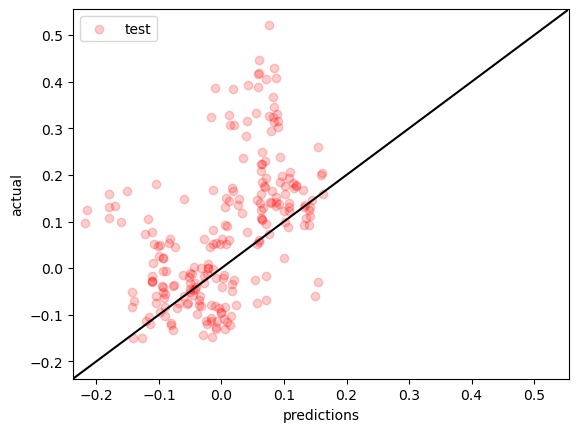

In [598]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(y_pred, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
perfect_line = np.arange(min(xmin, ymin), max(xmax, ymax), 0.01)
plt.plot(perfect_line, perfect_line, c='k')

# Set the same limits on x and y axes
plt.xlim([min(xmin, ymin), max(xmax, ymax)])
plt.ylim([min(xmin, ymin), max(xmax, ymax)])

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

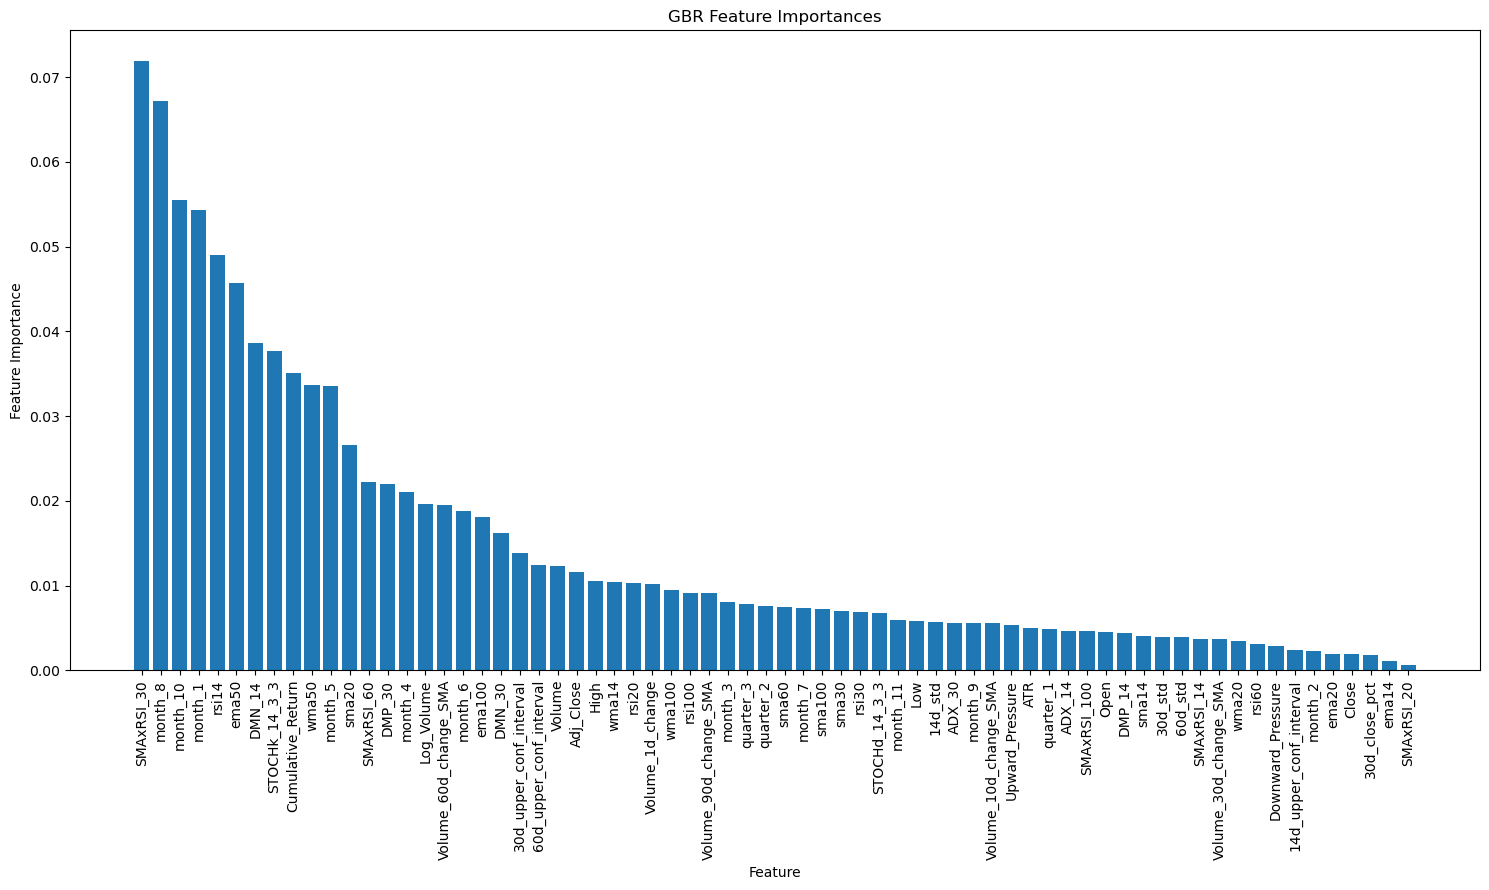

In [599]:
best_gb_model = grid_search_gb.best_estimator_.named_steps['gb']
feature_importances = best_gb_model.feature_importances_

feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 9))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBR Feature Importances")
plt.tight_layout()
plt.show()

In [600]:
with mlflow.start_run():

    # Log parameters
    mlflow.log_param("ticker", ticker)
    mlflow.log_param("scaling_method", "StandardScaler" if isinstance(scaler, StandardScaler) else "MinMaxScaler")
    mlflow.log_param("start_date", start_date)
    mlflow.log_param("target_variable", target)
    mlflow.log_param("features", features_to_scale)
    mlflow.log_param("categorical_features", categorical_features)
    mlflow.log_param("hyperparameters", grid_search_gb.best_params_)

    # Log metrics
    mlflow.log_metric(f'{refit_metric}', score)

     # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Model info", "Gradient Boosting Regressor")

    # Infer the model signature
    signature = infer_signature(X_train, best_model_gb.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_gb,
        artifact_path="gradient_boosting_regressor",
        signature=signature,
        input_example=X_train,
        registered_model_name=f'GBR_{refit_metric}',
    )

c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\user\anaconda3\envs\financial_ml_env\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be